In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# URL Download
import csv
import io
import urllib.request
import requests

2022-03-06 16:53:59.411846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 16:53:59.411910: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [6]:
df_theft = pd.read_csv("../raw_data/bike_theft_cleaned.csv")
df_theft.drop(columns = ["Unnamed: 0"], inplace = True)
df_theft.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start,datetime_theft_mean,BZR,PGR,Bezirk
0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,7100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00,0.0,2022-02-26 14:00:00,71001,710,7
1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,2100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00,0.0,2022-02-28 16:00:00,21001,210,2
2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,8300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00,0.0,2022-02-28 20:00:00,83009,830,8
3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,4400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00,0.0,2022-02-28 08:00:00,44007,440,4
4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,9100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00,12.0,2022-02-25 11:00:00,91003,910,9


In [7]:
# Group dataframe by date and LOR
df_theft = df_theft.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft.fillna(value = 0, inplace=True)

In [8]:
df_theft

Bezirk,1,2,3,4,5,6,7,8,9,10,11,12
date_theft_start,,,,,,,,,,,,
2021-01-01,1.0,4.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0
2021-01-02,0.0,0.0,5.0,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0
2021-01-03,1.0,1.0,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0
2021-01-04,6.0,7.0,3.0,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0
2021-01-05,7.0,2.0,2.0,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,3.0,10.0,14.0,3.0,0.0,4.0,7.0,4.0,5.0,0.0,1.0,1.0
2022-02-25,3.0,6.0,6.0,5.0,2.0,3.0,5.0,1.0,5.0,3.0,2.0,1.0
2022-02-26,4.0,2.0,3.0,1.0,1.0,3.0,4.0,2.0,0.0,0.0,1.0,0.0


## Show the number of thefts per Bezirk over time

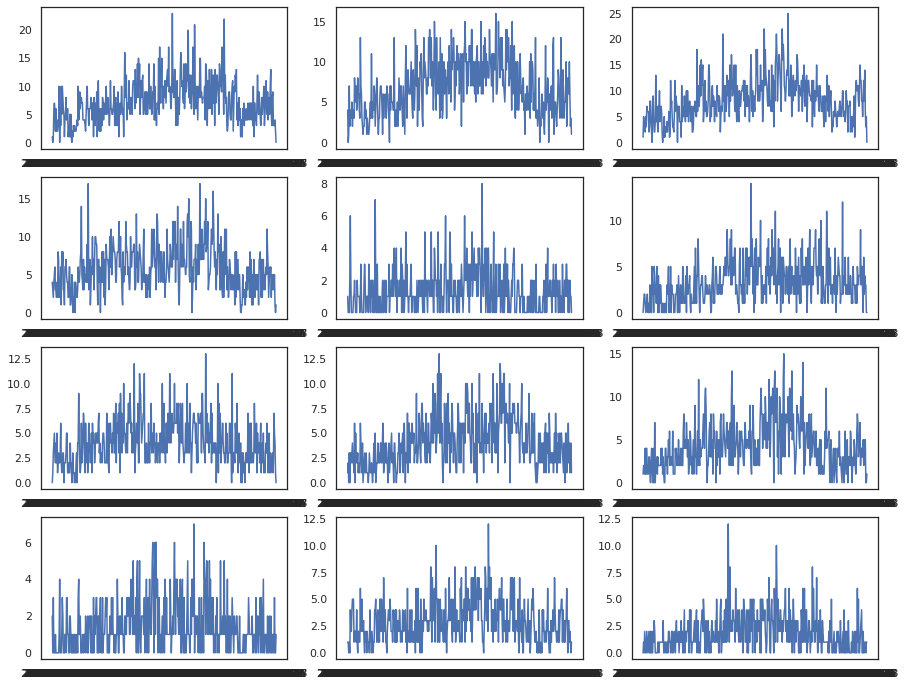

In [33]:
fig, axs = plt.subplots(4, 3, figsize = (15, 12))
axs[0, 0].plot(df_theft[1])
axs[0, 1].plot(df_theft[2])
axs[0, 2].plot(df_theft[3])
axs[1, 0].plot(df_theft[4])
axs[1, 1].plot(df_theft[5])
axs[1, 2].plot(df_theft[6])
axs[2, 0].plot(df_theft[7])
axs[2, 1].plot(df_theft[8])
axs[2, 2].plot(df_theft[9])
axs[3, 0].plot(df_theft[10])
axs[3, 1].plot(df_theft[11])
axs[3, 2].plot(df_theft[12])
 
plt.show();

In [14]:
type(df_theft)

pandas.core.frame.DataFrame

In [10]:
df_theft.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='Bezirk')

In [13]:
df_theft.dtypes

Bezirk
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
dtype: object

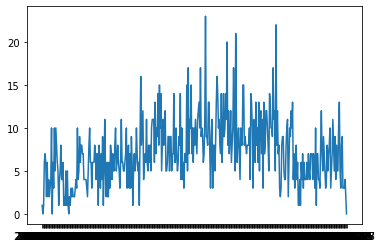

In [11]:
plt.plot(df_theft[1])

In [18]:
df_theft[1]

date_theft_start
2021-01-01    1.0
2021-01-02    0.0
2021-01-03    1.0
2021-01-04    6.0
2021-01-05    7.0
             ... 
2022-02-24    3.0
2022-02-25    3.0
2022-02-26    4.0
2022-02-27    2.0
2022-02-28    0.0
Name: 1, Length: 424, dtype: float64

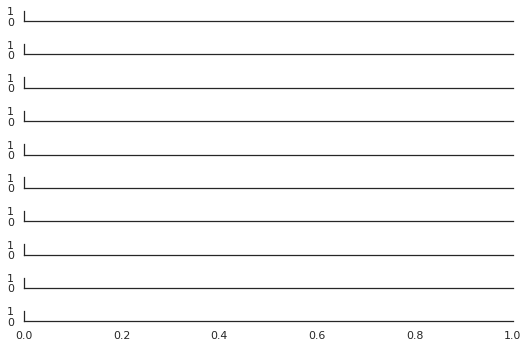

In [21]:
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/seaborn/axisgrid.py:88:

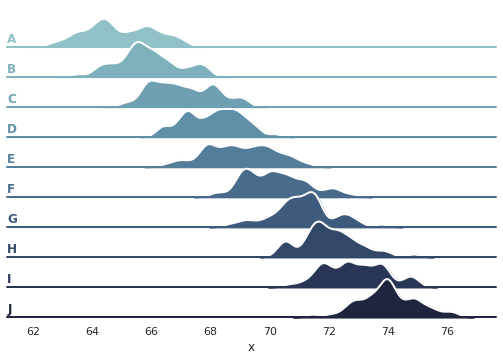

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)